In [1]:
import numpy as np
import numpy.linalg as npla
from scipy.io import loadmat
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib widget
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times"],
        "font.size": 14,
    }
)

from pysteam import evaluable, problem, solver
from pysteam.evaluable import vspace

In [2]:
data = loadmat("dataset1.mat")
x_true = data["x_true"][..., None]  # ground truth x (12709, 1, 1)
K = x_true.shape[0]  # 12709
dt = 0.1  # sampling period
t = data["t"] * dt  # timestamps (12709, 1)
# motion
u = data["v"][..., None]  # velocity measurements (12709, 1, 1)
u_cov = data["v_var"]
v = u * dt
v_cov = u_cov * dt**2
# observation
l = data["l"][..., None]  # ground truth landmark location (1, 1, 1)
r = data["r"][..., None]  # raw range measurements (12709, 1, 1)
y = l - r  # corrected range measurements (12709, 1, 1)
r_cov = data["r_var"]  # range measurement variance
# initial state (arbitrarily chosen for filters)
x0 = x_true[0]
x0_cov = np.eye(1) * 0.001

$$
\text{motion:}\quad x_k = x_{k-1} + Tu_k + w_k = x_{k-1} + v_k + w_k \\
\text{observation:}\quad y_k = x_c - r_k = x_k + n_k
$$


In [3]:
class MotionError(evaluable.Evaluable):
    def __init__(self, xk, xkm1, vk):
        super().__init__()
        self._xk = xk
        self._xkm1 = xkm1
        self._vk = vk

    @property
    def active(self) -> bool:
        return self._xk.active or self._xkm1.active

    @property
    def related_var_keys(self) -> set:
        return self._xk.related_var_keys | self._xkm1.related_var_keys

    def forward(self):
        xk = self._xk.forward()
        xkm1 = self._xkm1.forward()
        error = xk.value - xkm1.value - self._vk
        return evaluable.Node(error, xk, xkm1)

    def backward(self, lhs, node, jacs) -> None:
        if self._xk.active:
            self._xk.backward(lhs, node.children[0], jacs)
        if self._xkm1.active:
            self._xkm1.backward(-lhs, node.children[1], jacs)


class ObservationError(evaluable.Evaluable):
    def __init__(self, xk, yk):
        super().__init__()
        self._xk = xk
        self._yk = yk

    @property
    def active(self) -> bool:
        return self._xk.active

    @property
    def related_var_keys(self) -> set:
        return self._xk.related_var_keys

    def forward(self):
        xk = self._xk.forward()
        error = self._yk - xk.value
        return evaluable.Node(error, xk)

    def backward(self, lhs, node, jacs) -> None:
        if self._xk.active:
            self._xk.backward(-lhs, node.children[0], jacs)

## Batch Estimation


Begin Optimization
------------------
Number of States:  12709
Number of Cost Terms:  25418
Initial Cost:  66779645.37411017
Iteration:    1  -  Cost:  1307.2615
Iteration:    2  -  Cost:  1307.2615
Termination Cause:  CONVERGED ABSOLUTE CHANGE


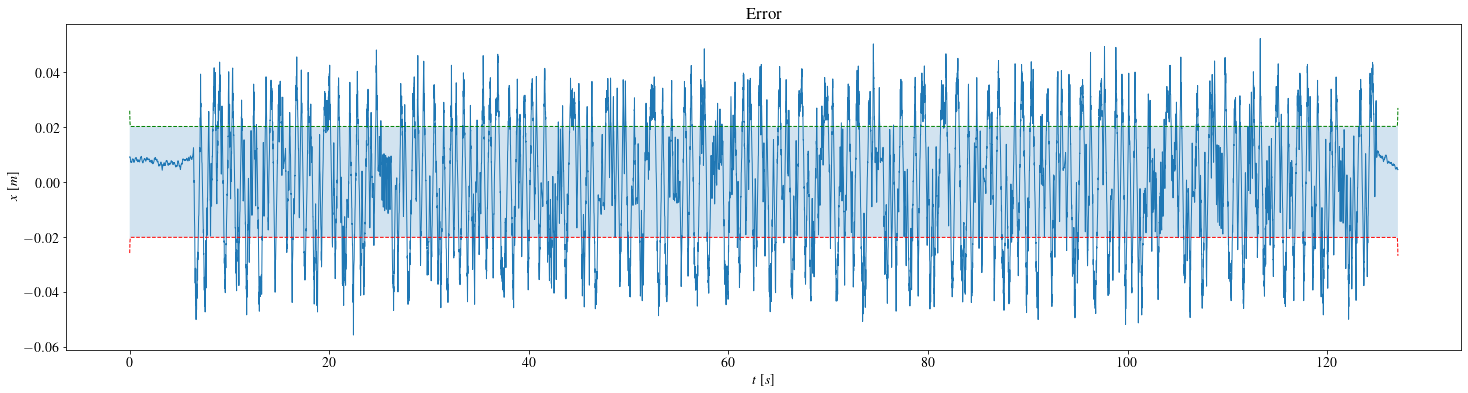

In [4]:
# variable
x_var = [vspace.VSpaceStateVar(np.zeros((1, 1))) for _ in range(K)]

opt_prob = problem.OptimizationProblem(use_sparse_matrix=True)
opt_prob.add_state_var(*x_var)

# initial state prior
loss_func = problem.L2LossFunc()
noise_model = problem.StaticNoiseModel(x0_cov)
error_func = vspace.vspace_error(x_var[0], x0)
opt_prob.add_cost_term(
    problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
)

# motion prior
loss_func = problem.L2LossFunc()
noise_model = problem.StaticNoiseModel(v_cov)
for k in range(1, K):
    error_func = MotionError(x_var[k], x_var[k - 1], v[k])
    opt_prob.add_cost_term(
        problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    )

# observation
loss_func = problem.L2LossFunc()
noise_model = problem.StaticNoiseModel(r_cov)
for k in range(0, K):
    error_func = ObservationError(x_var[k], y[k])
    opt_prob.add_cost_term(
        problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    )

optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

covariance = solver.Covariance(opt_prob)

x_hat = np.stack([x.value for x in x_var], axis=0)
x_cov_hat = np.concatenate([covariance.query(x_var[k]) for k in range(K)])
x_std_hat = np.sqrt(x_cov_hat)

t = t.squeeze()
error = (x_true - x_hat).squeeze()
x_std_hat = x_std_hat.squeeze()

fig = plt.figure(figsize=(25, 6))
ax = fig.add_subplot(111)
ax.plot(t, error, linewidth=1.0)
ax.plot(t, -3 * x_std_hat, "r--", linewidth=1.0)
ax.plot(t, +3 * x_std_hat, "g--", linewidth=1.0)
plt.fill_between(t, -3 * x_std_hat, 3 * x_std_hat, alpha=0.2)
ax.set_title("Error")
ax.set_xlabel(r"$t$ [$s$]")
ax.set_ylabel(r"$x$ [$m$]")
plt.show()

batch_x_hat = x_hat
batch_x_std_hat = x_std_hat

## Standard Kalman Filter


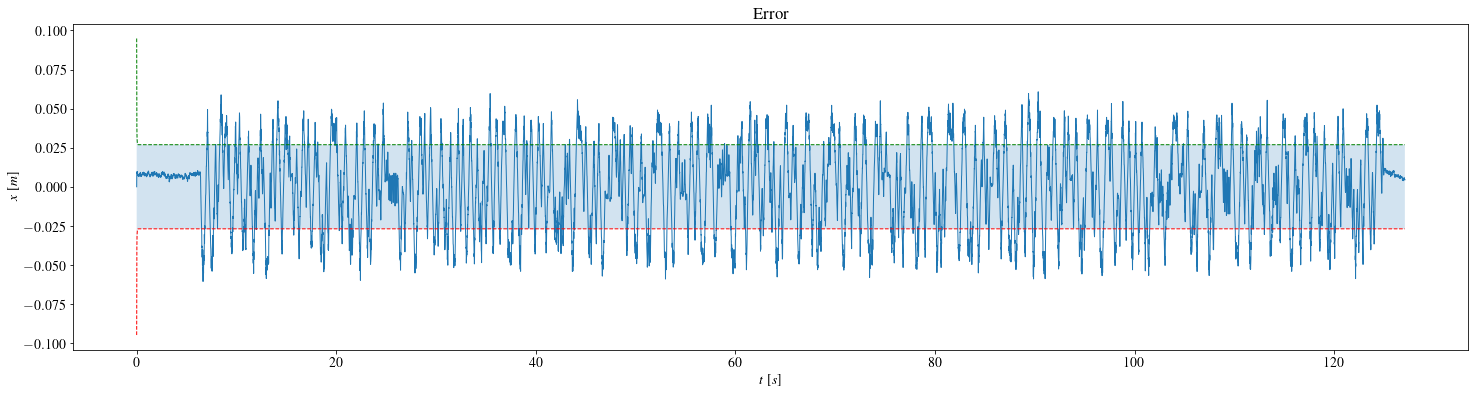

In [5]:
x_hat = []
x_cov_hat = []

# initial state
x_hat.append(x0)
x_cov_hat.append(x0_cov)

# filter update
for k in range(1, K):
    print(f"KF: step {k} - {k / K * 100:4.2f}%", end="\r")

    xkm1 = x_hat[k - 1]
    xkm1_cov = x_cov_hat[k - 1]

    xk_pred = xkm1 + v[k]
    xk_cov_pred = xkm1_cov + v_cov

    Kk = xk_cov_pred @ np.linalg.inv(xk_cov_pred + r_cov)

    xk = xk_pred + Kk @ (y[k] - xk_pred)
    xk_cov = xk_cov_pred - Kk @ xk_cov_pred

    x_hat.append(xk)
    x_cov_hat.append(xk_cov)

x_hat = np.stack(x_hat, axis=0)
x_cov_hat = np.concatenate(x_cov_hat, axis=0)
x_std_hat = np.sqrt(x_cov_hat)

t = t.squeeze()
error = (x_true - x_hat).squeeze()
x_std_hat = x_std_hat.squeeze()

fig = plt.figure(figsize=(25, 6))
ax = fig.add_subplot(111)
ax.plot(t, error, linewidth=1.0)
ax.plot(t, -3 * x_std_hat, "r--", linewidth=1.0)
ax.plot(t, +3 * x_std_hat, "g--", linewidth=1.0)
plt.fill_between(t, -3 * x_std_hat, 3 * x_std_hat, alpha=0.2)
ax.set_title("Error")
ax.set_xlabel(r"$t$ [$s$]")
ax.set_ylabel(r"$x$ [$m$]")
plt.show()

kf_x_hat = x_hat
kf_x_std_hat = x_std_hat

## Kalman Filter via MAP


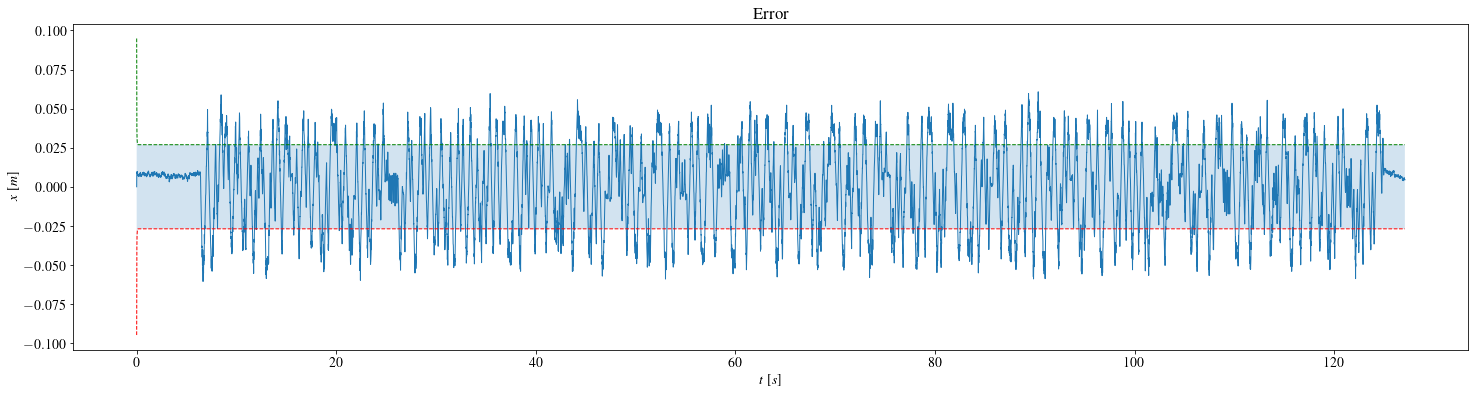

In [6]:
x_hat = []
x_cov_hat = []

# initial state
x_hat.append(x0)
x_cov_hat.append(x0_cov)

# filter update
for k in range(1, K):
    print(f"KF: step {k} - {k / K * 100:4.2f}%", end="\r")

    # optimization problem
    opt_prob = problem.OptimizationProblem(use_sparse_matrix=False)

    # state (linear problem, initial value does not matter)
    xkm1_var = vspace.VSpaceStateVar(np.zeros((1, 1)))
    xk_var = vspace.VSpaceStateVar(np.zeros((1, 1)))
    opt_prob.add_state_var(xkm1_var, xk_var)

    # xkm1 prior
    xkm1 = x_hat[k - 1]
    xkm1_cov = x_cov_hat[k - 1]
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(xkm1_cov)
    error_func = vspace.vspace_error(xkm1_var, xkm1)
    opt_prob.add_cost_term(
        problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    )

    # motion prior
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(v_cov)
    error_func = MotionError(xk_var, xkm1_var, v[k])
    opt_prob.add_cost_term(
        problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    )

    # observation
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(r_cov)
    error_func = ObservationError(xk_var, y[k])
    opt_prob.add_cost_term(
        problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    )

    optimizer = solver.GaussNewtonSolver(opt_prob, max_iterations=1)
    optimizer.optimize()
    covariance = solver.Covariance(opt_prob)

    x_hat.append(xk_var.value)
    x_cov_hat.append(covariance.query(xk_var))

x_hat = np.stack(x_hat, axis=0)
x_cov_hat = np.concatenate(x_cov_hat, axis=0)
x_std_hat = np.sqrt(x_cov_hat)

t = t.squeeze()
error = (x_true - x_hat).squeeze()
x_std_hat = x_std_hat.squeeze()

fig = plt.figure(figsize=(25, 6))
ax = fig.add_subplot(111)
ax.plot(t, error, linewidth=1.0)
ax.plot(t, -3 * x_std_hat, "r--", linewidth=1.0)
ax.plot(t, +3 * x_std_hat, "g--", linewidth=1.0)
plt.fill_between(t, -3 * x_std_hat, 3 * x_std_hat, alpha=0.2)
ax.set_title("Error")
ax.set_xlabel(r"$t$ [$s$]")
ax.set_ylabel(r"$x$ [$m$]")
plt.show()

kfmap_x_hat = x_hat
kfmap_x_std_hat = x_std_hat
assert np.allclose(kfmap_x_hat, kf_x_hat)
assert np.allclose(kfmap_x_std_hat, kf_x_std_hat)

## Kalman Filter via Sliding-Window Filter


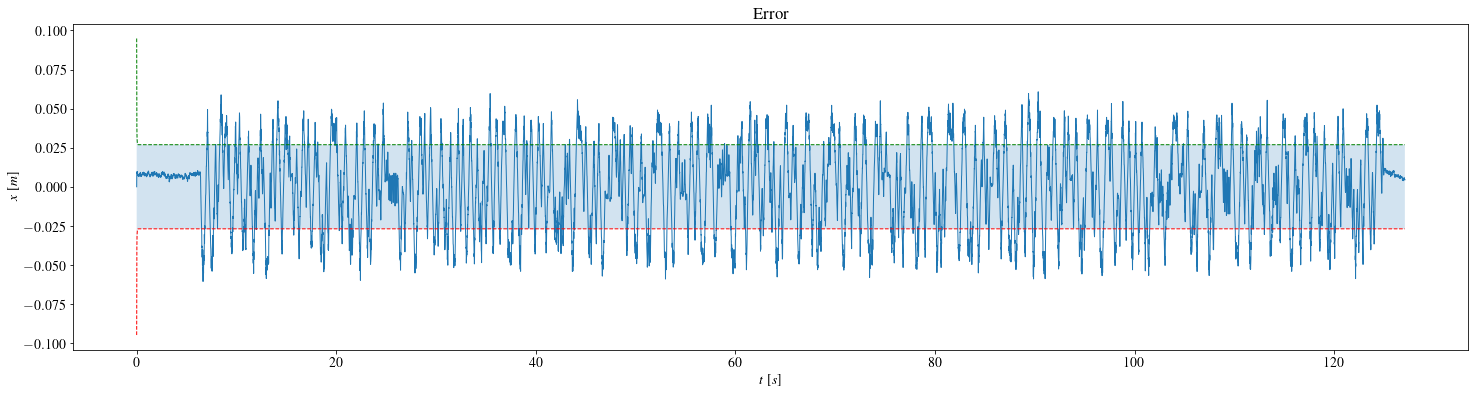

In [7]:
x_hat = []
x_cov_hat = []

# create a sliding window filter
swfilter = problem.SlidingWindowFilter()

# add initial variable
x_var = [vspace.VSpaceStateVar(np.zeros((1, 1)), name="x0")]
swfilter.add_variable(x_var[0])

# initial state prior
loss_func = problem.L2LossFunc()
noise_model = problem.StaticNoiseModel(x0_cov)
error_func = vspace.vspace_error(x_var[0], x0)
swfilter.add_cost_term(
    problem.WeightedLeastSquareCostTerm(
        error_func, noise_model, loss_func, name=f"x{0}-prior"
    )
)

# initial state
x_hat.append(x0)
x_cov_hat.append(x0_cov)

# filter update
for k in range(1, K):
    print(f"KF: step {k} - {k / K * 100:4.2f}%", end="\r")

    # add a new variable
    x_var.append(vspace.VSpaceStateVar(np.zeros((1, 1)), name=f"x{k}"))
    swfilter.add_variable(x_var[k])

    # state (linear problem, initial value does not matter)
    xkm1_var, xk_var = x_var[k - 1], x_var[k]

    # motion prior
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(v_cov)
    error_func = MotionError(xk_var, xkm1_var, v[k])
    swfilter.add_cost_term(
        problem.WeightedLeastSquareCostTerm(
            error_func, noise_model, loss_func, name=f"x{k-1}-x{k}-motion"
        )
    )

    # observation
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(r_cov)
    error_func = ObservationError(xk_var, y[k])
    swfilter.add_cost_term(
        problem.WeightedLeastSquareCostTerm(
            error_func, noise_model, loss_func, name=f"x{k}-observation"
        )
    )

    # marginalize before optimizing
    swfilter.marginalize_variable(xkm1_var)

    optimizer = solver.GaussNewtonSolver(swfilter, max_iterations=1)
    optimizer.optimize()
    covariance = solver.Covariance(swfilter)

    x_hat.append(xk_var.value)
    x_cov_hat.append(covariance.query(xk_var))

x_hat = np.stack(x_hat, axis=0)
x_cov_hat = np.concatenate(x_cov_hat, axis=0)
x_std_hat = np.sqrt(x_cov_hat)

t = t.squeeze()
error = (x_true - x_hat).squeeze()
x_std_hat = x_std_hat.squeeze()

fig = plt.figure(figsize=(25, 6))
ax = fig.add_subplot(111)
ax.plot(t, error, linewidth=1.0)
ax.plot(t, -3 * x_std_hat, "r--", linewidth=1.0)
ax.plot(t, +3 * x_std_hat, "g--", linewidth=1.0)
plt.fill_between(t, -3 * x_std_hat, 3 * x_std_hat, alpha=0.2)
ax.set_title("Error")
ax.set_xlabel(r"$t$ [$s$]")
ax.set_ylabel(r"$x$ [$m$]")
plt.show()

swf_x_hat = x_hat
swf_x_std_hat = x_std_hat
assert np.allclose(swf_x_hat, kf_x_hat)
assert np.allclose(swf_x_std_hat, kf_x_std_hat)